<a href="https://colab.research.google.com/github/HarVarsh/MachneLearning/blob/main/Shaastra_Techathon_solution_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
import xgboost as xgb
#------------------------------------------Metrics-------------------------------------------------------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    absolute_error = np.abs(y_true - y_pred)
    percentage_error = absolute_error / np.maximum(np.abs(y_true), 1.0)  # Avoid division by zero
    modified_absolute_percentage_error = np.where(y_true == 0, absolute_error, percentage_error * (1 + percentage_error))
    return np.mean(modified_absolute_percentage_error)

In [ ]:
train_df = pd.read_csv('/content/train_data_covid.csv')
test_df = pd.read_csv('/content/test_data_covid.csv')
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15001 entries, 0 to 15000
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       15001 non-null  int64 
 1   Date                      15001 non-null  object
 2   Time                      15001 non-null  object
 3   State/UnionTerritory      15001 non-null  object
 4   ConfirmedIndianNational   15001 non-null  object
 5   ConfirmedForeignNational  15001 non-null  object
 6   Cured                     15001 non-null  int64 
 7   Deaths                    15001 non-null  int64 
 8   Confirmed                 15001 non-null  int64 
 9   OxygenTanks               15001 non-null  int64 
 10  PopulationDensityPerSqKm  15001 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.3+ MB
None


,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,OxygenTanks,PopulationDensityPerSqKm
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1,8262,867
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1,9136,61
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2,3826,316
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3,9789,806
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3,882,369


In [ ]:
train_df['State/UnionTerritory'].unique()

array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya',
       'Dadra and Nagar Haveli and Daman and Diu',
       'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
       'Lakshadweep', 'Telangana'], dtype=object)

In [ ]:
class DataPreprocessor:
    def __init__(self):
        pass

    def preprocess_data(self, df):
        #'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        df['Day'] = df['Date'].dt.day
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        #(replace '-' with 0)
        df['ConfirmedIndianNational'] = df['ConfirmedIndianNational'].replace('-', 0)
        df['ConfirmedForeignNational'] = df['ConfirmedForeignNational'].replace('-', 0)

        # Convert columns to integers
        df['ConfirmedIndianNational'] = df['ConfirmedIndianNational'].astype(int)
        df['ConfirmedForeignNational'] = df['ConfirmedForeignNational'].astype(int)

        # Fill 'Cases being reassigned to states' with 0
        df['State/UnionTerritory'] = df['State/UnionTerritory'].replace('Cases being reassigned to states', 0)

        # Assign numerical values from 0 to N for State/UnionTerritory
        state_mapping = {state: i for i, state in enumerate(df['State/UnionTerritory'].unique())}
        df['State/UnionTerritory'] = df['State/UnionTerritory'].map(state_mapping)

        return df

preprocessor = DataPreprocessor()

# Preprocess the training data
train_df = preprocessor.preprocess_data(train_df)
test_df = preprocessor.preprocess_data(test_df)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Choose features and target variable
features = ['Day', 'Month', 'Year', 'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured', 'Confirmed', 'OxygenTanks', 'PopulationDensityPerSqKm', 'State/UnionTerritory']
target = 'Deaths'

X = train_df[features]
y = train_df[target]

X_sub = test_df[features]

In [ ]:
X.sample(5)

,Day,Month,Year,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Confirmed,OxygenTanks,PopulationDensityPerSqKm,State/UnionTerritory
7619,23,10,2020,0,0,312918,344318,4514,321,2
5673,28,8,2020,0,0,500,974,3336,524,24
1099,19,4,2020,0,0,6,7,436,250,26
7391,16,10,2020,0,0,27365,32486,812,662,15
5858,2,9,2020,0,0,14076,20398,5934,339,13


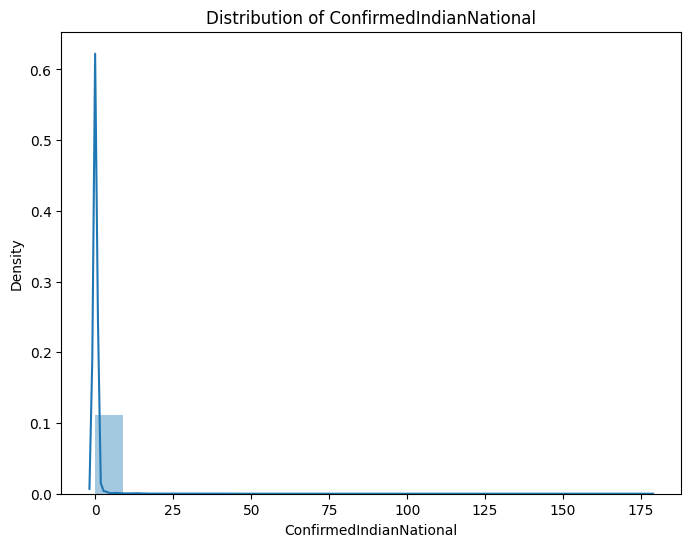

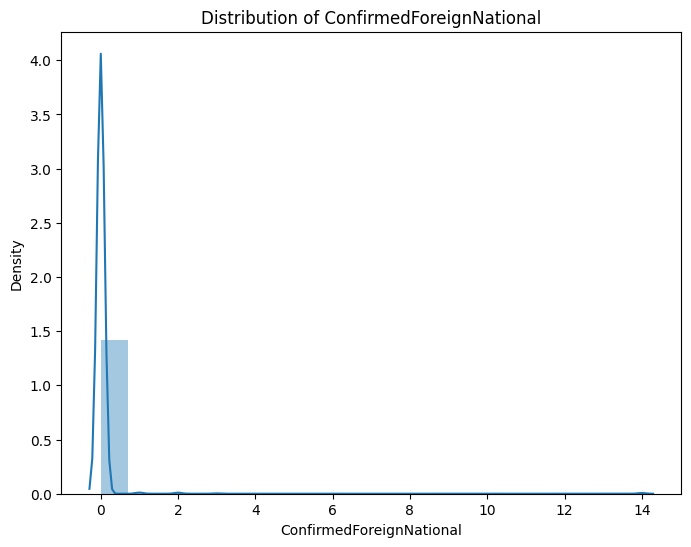

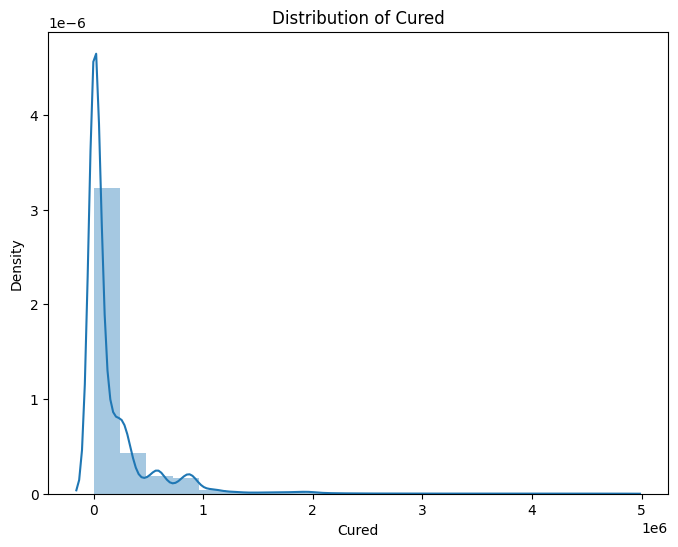

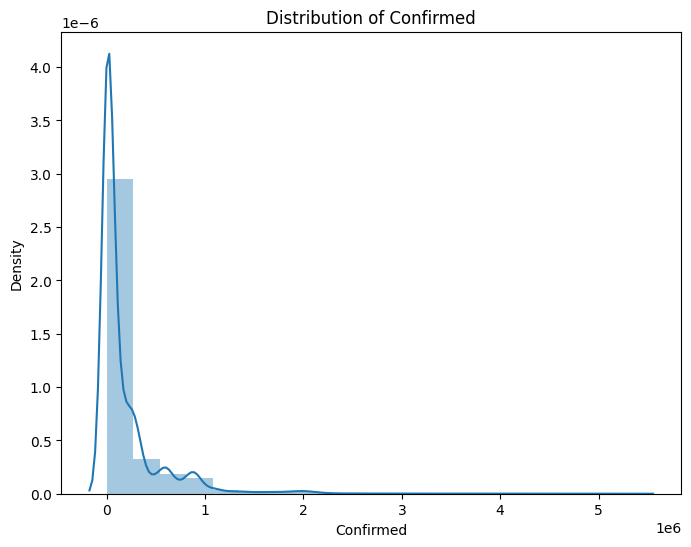

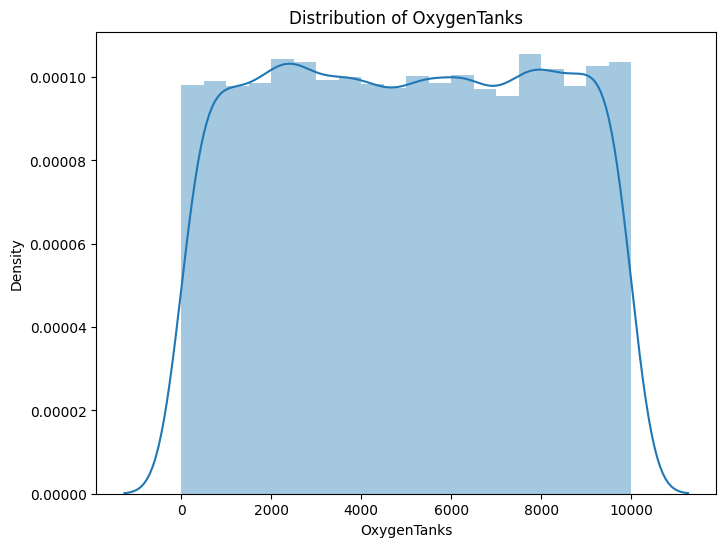

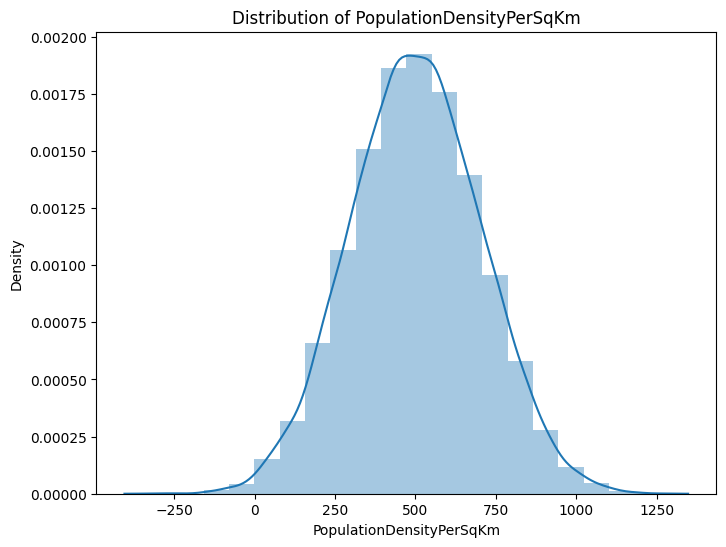

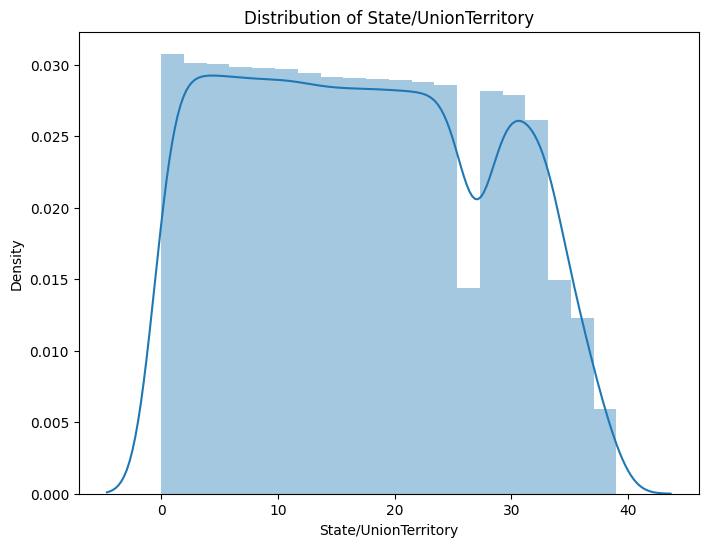

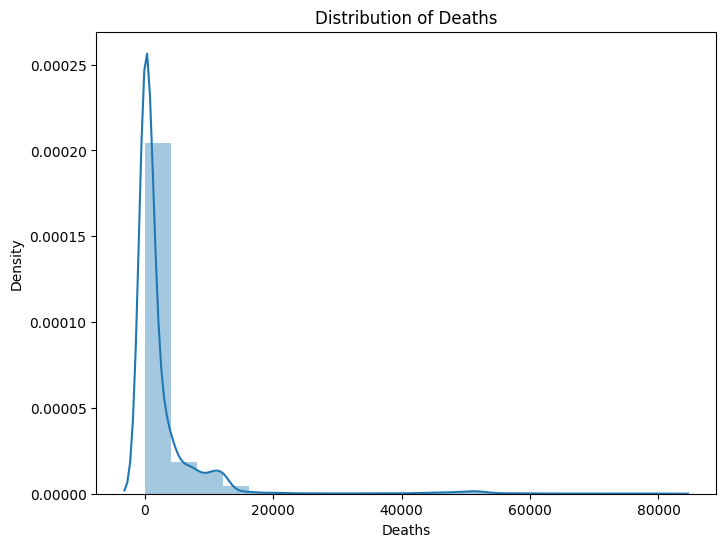

In [ ]:
# Get distributions for numerical features
numeric_features = ['ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured', 'Confirmed', 'OxygenTanks', 'PopulationDensityPerSqKm','State/UnionTerritory', 'Deaths']

for feature in numeric_features:
   plt.figure(figsize=(8, 6))
   sns.distplot(train_df[feature], bins=20, kde=True)
   plt.title(f'Distribution of {feature}')
   plt.show()

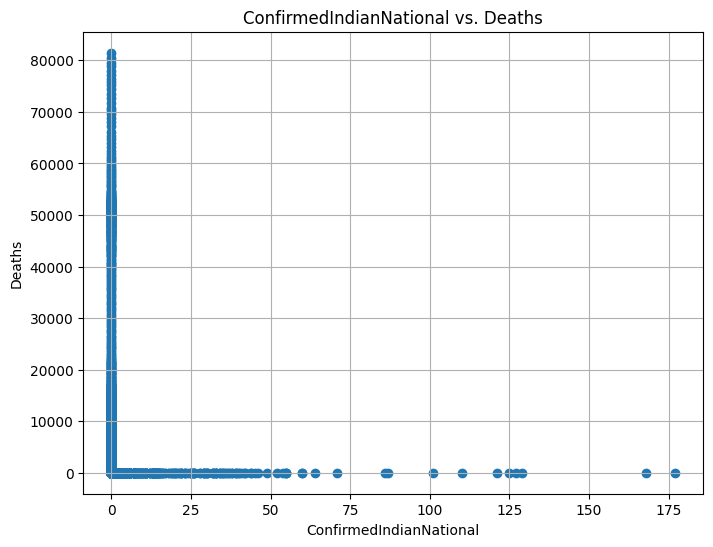

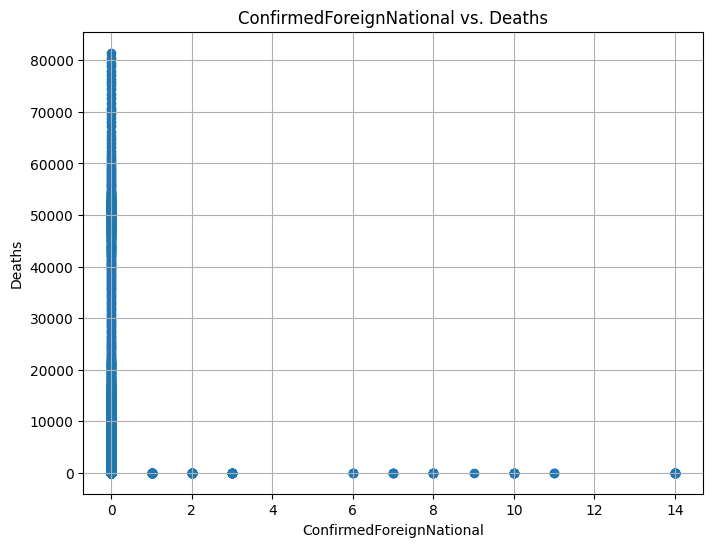

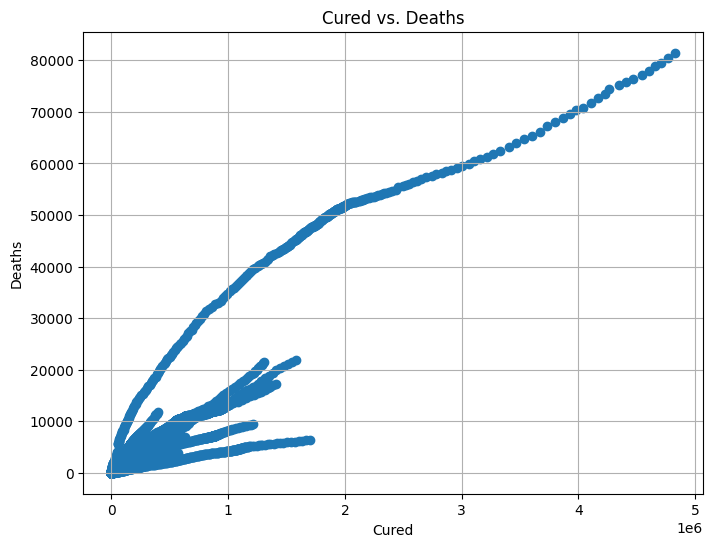

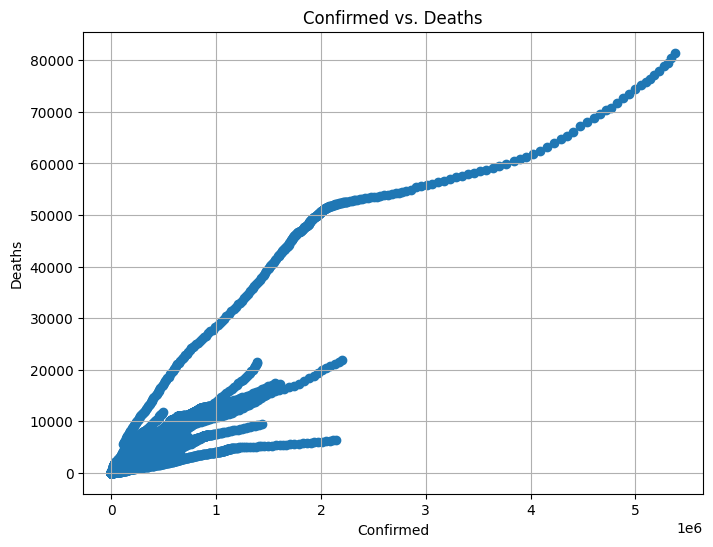

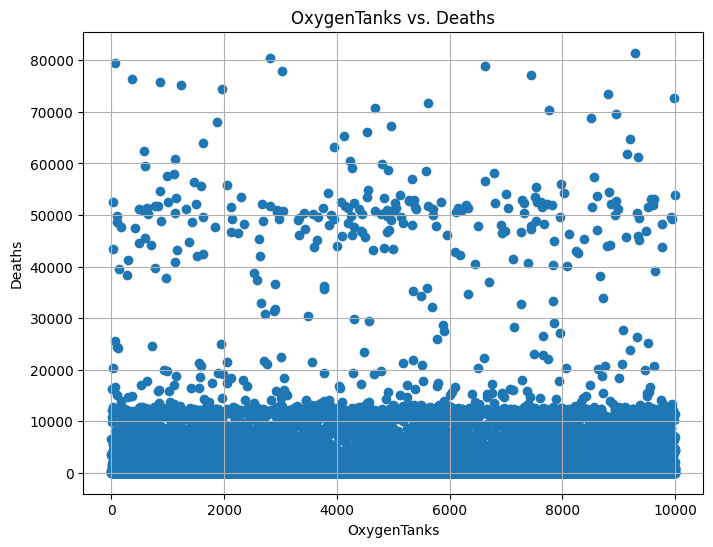

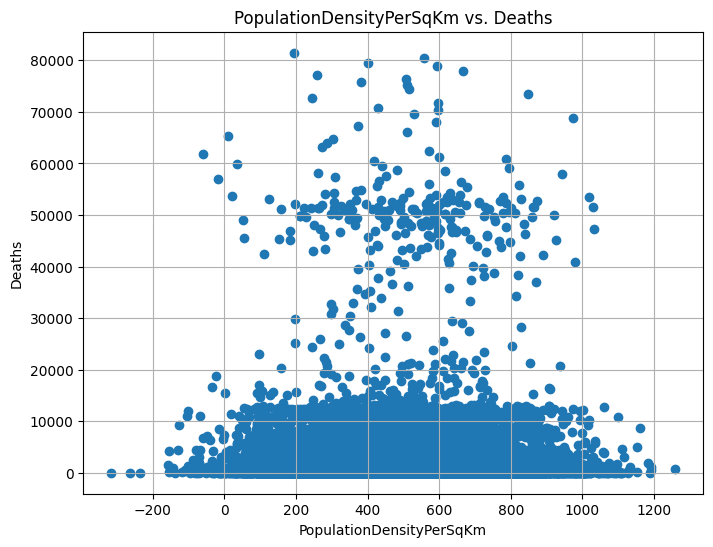

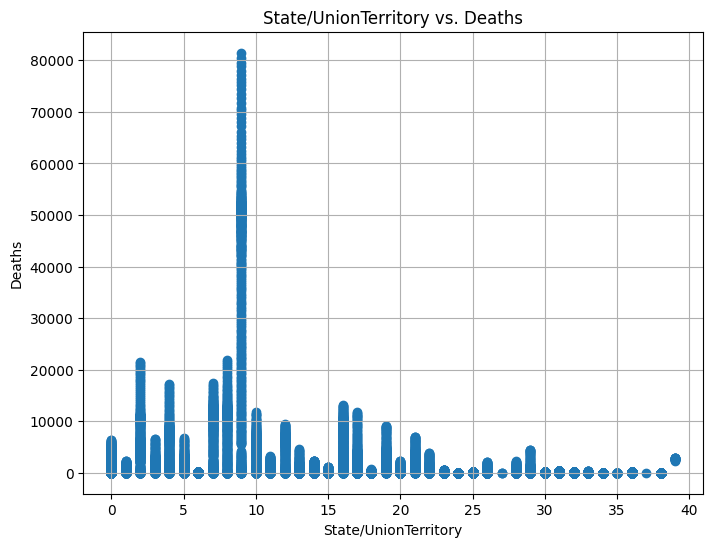

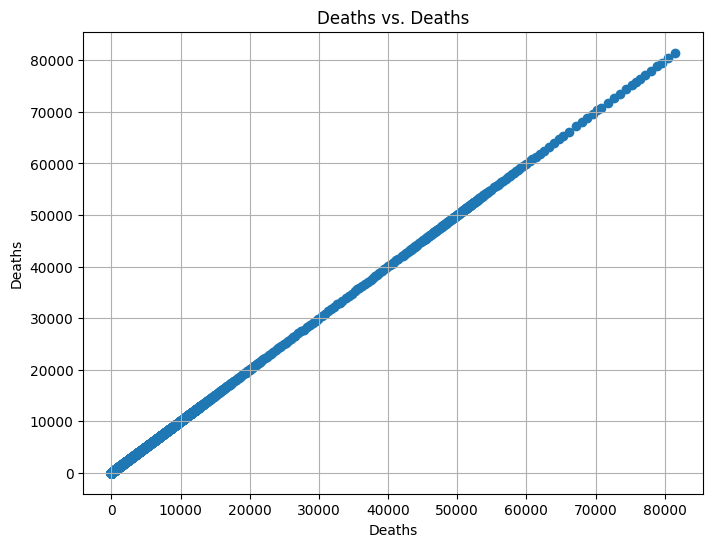

In [ ]:
# Scatter plots for each feature vs. Deaths
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(train_df[feature], train_df['Deaths'])
    plt.title(f'{feature} vs. Deaths')
    plt.xlabel(feature)
    plt.ylabel('Deaths')
    plt.grid(True)
    plt.show()

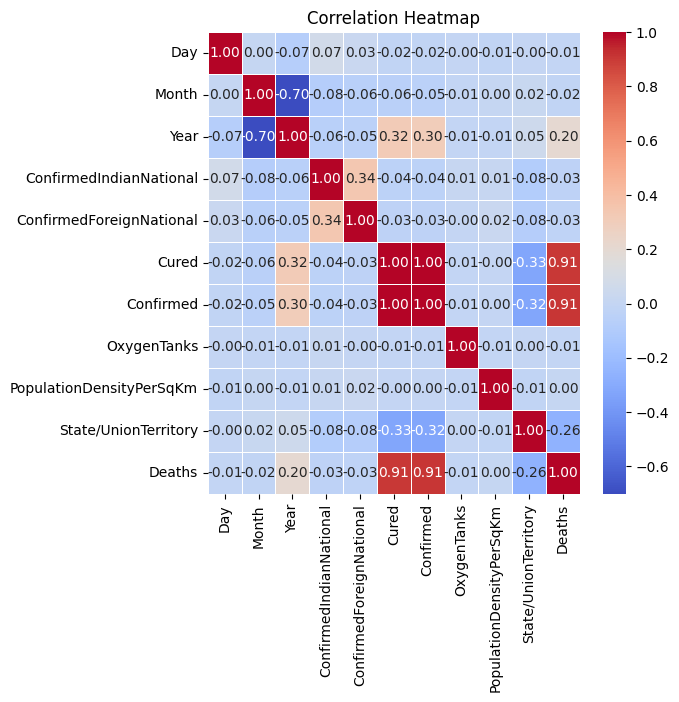

In [ ]:
train_data = pd.concat([X, y], axis=1)

#sns.pairplot(train_data)
#plt.show()

# Correlation heatmap
corr_matrix = train_data.corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import warnings

xg_param = {
    'max_depth': [3, 5, 7, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 700, 900],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

rf_param = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svr_param = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.3, 0.4]
}

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

def get_params(model, param_grid, loss_function, X_train, y_train, X_val, y_val):
    warnings.filterwarnings("ignore")
    scorer = make_scorer(loss_function, greater_is_better=False)
    model = model

    print(f'Getting :{model.__class__.__name__} params:\\n')
    randomized_search = RandomizedSearchCV(model, param_grid, scoring=scorer, cv=5, n_iter=10)
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    best_params = best_model.get_params()

    param_string = " | ".join([f"{key}: {value}" for key, value in best_params.items() if value is not None])
    print(param_string)
    print('\n')

    return best_params

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# xg_mse_params = get_params(xgb.XGBRegressor(tree_method='gpu_hist'), xg_param, mean_absolute_percentage_error, X_train, y_train, X_train, y_train)
rf_mse_params = get_params(RandomForestRegressor(), rf_param, mean_absolute_percentage_error, X_train, y_train, X_train, y_train)
# svr_mse_params = get_params(SVR(), svr_param, mean_absolute_percentage_error, X_train, y_train, X_train, y_train)

# Getting :XGBRegressor params:\n
# objective: reg:squarederror | colsample_bytree: 0.9 | enable_categorical: False | gamma: 0.1 | learning_rate: 0.01 | max_depth: 7 | missing: nan | n_estimators: 300 | reg_alpha: 1.0 | reg_lambda: 0.5 | subsample: 1.0 | tree_method: gpu_hist


# Getting :RandomForestRegressor params:\n
# bootstrap: True | ccp_alpha: 0.0 | criterion: squared_error | max_depth: 30 | max_features: 1.0 | min_impurity_decrease: 0.0 | min_samples_leaf: 2 | min_samples_split: 2 | min_weight_fraction_leaf: 0.0 | n_estimators: 200 | oob_score: False | verbose: 0 | warm_start: False

Getting :RandomForestRegressor params:\n
bootstrap: True | ccp_alpha: 0.0 | criterion: squared_error | max_depth: 30 | max_features: 1.0 | min_impurity_decrease: 0.0 | min_samples_leaf: 1 | min_samples_split: 5 | min_weight_fraction_leaf: 0.0 | n_estimators: 200 | oob_score: False | verbose: 0 | warm_start: False




In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_reg = RandomForestRegressor(**rf_mse_params)

rf_reg.fit(X_train, y_train)
predictions = rf_reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"rf mape: {mape:.4f}")

rf mape: 0.2560


In [ ]:
predictions = rf_reg.predict(X_sub)

submission_df = pd.DataFrame({
    'Sno': test_df['Sno'],
    'Deaths': predictions
})

submission_df.to_csv('get_submission.csv', index=False)